<a href="https://colab.research.google.com/github/jyeoum/BiologicallyIntelligentExploration/blob/main/Labs/Lab9_Information_seeking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 - Information Seeking in Reinforcement Learning

This lab has a number components designed to investigate different strategies of information seeking in reinforcement learning, including those beyond $\epsilon$-greedy.

Sections:
1. Building a different environment
1. Trying out some new, more sophisticated agents, in the new environment
1. Testing the agents in a more complex (changing) environment

## Background

- In the last lab, we got familiar with basic Q-learning and action selection algorithms (random, sequential, and  $\epsilon$-greedy).
- We focused on the "exploitation" (reward maximization) side of the exploration-exploitation dilemma.
- However, as we found, exploration is intertwined with exploitation in a complex way (one must explore to estimate which options may give the most reward).
- In fact, the question of how to maximize reward in such a formulation is *mathematically intractible*.
- Furthermore, the performance of different exploration/exploitation strategies are heavily dependent on environment/task structure.

### Question 0.1
What are some limitations/drawbacks of the $\epsilon$-greedy algorithm? *Hint: think long-term.*

In [1]:
# Without greed, exploration becomes directionless and becomes sub-optimal. It can also be greedy for the wrong thing and end up getting stuck.
# In the long-term, the algorithm would essentially be losing out as new and better options or epsilon values pop up.

## Section - Setup

In [2]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-b0h9n51c
  Running command git clone -q https://github.com/coaxlab/explorationlib /tmp/pip-req-build-b0h9n51c
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=24681 sha256=52a798d9da2df3530957ad03fd56cdc5be410f91f6b903ea3279b95403430415
  Stored in directory: /tmp/pip-ephem-wheel-cache-xn5fy4q2/wheels/33/38/07/7f61d2c279b8eed0cbef923c5315580ce93146145ca01ca407
Successfully built explorationlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-1a7zgz8p
  Running command git clone -q https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-1a7zgz8p
     |████████████████████████████████| 21.8 MB 1.5 MB/s 
  Created wheel for gym-maze: filename=gym_maze-

In [3]:
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib

from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditChange4
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import DeterministicActor

from explorationlib.run import experiment
from explorationlib.score import total_reward
from explorationlib.score import action_entropy
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

In [4]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - The environment

Here, we make a new environment which is much like the one from the last lab, except the probability of reward from the "best" arm is now 0.6 instead of 0.35.

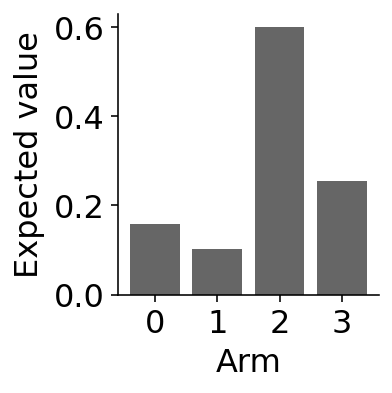

In [5]:
# Shared env params
num_experiments = 1
seed = 5030

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.6)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

## Question 1.1
Compared to the bandit task from the last lab, do you think this one is easier? Why?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

## Section 2 - Old & new agents

Old agents:
1. Random actor agent
1. Sequential actor agent
1. Epsilon-greedy actor agent

New agents:
3. Upper confidence bound agent
1. Novelty critic agent (with epsilon-greedy actor)
1. Softmax actor agent

#### **Upper confidence bound critic**
The upper confindence bound agent takes a measure of uncertainty into account before action selection.
- A "bonus" is factored into the estimated value of each action before selection.
- This bonus takes into account the number of times each action has been selected, giving a boost to the estimated values of actions which have not been tried very often.
- The agent then selects the action with the highest combined score value estimate and bonus, *deterministically*.
- The combined score for an action $s$ is calculated according to the formula below (where $N_t(a)$ is how many times action $a$ has been tried up to time $t$, and $c$ is the bonus scaling):

$$Q_t(a) + c\sqrt{\dfrac{\text{log}(t)}{N_t(a)}}$$

#### **Novelty bonus agent**
The novelty bonus agent works just like our original epsilon-greedy agent, except it gives itself a boosted reward (actual reward plus `novelty_bonus`) each time it encounters a state that it has never experienced before. Because we are in a bandit environment, this bonus will only occue once.

#### **Softmax action selection**
Softmax action selction has to do with how to choose an action given Q-value estimates for each action. In other words, it is an alternative to epsilon-greedy.
- In softmax action selection, actions are chosen probabilistically.
- Actions with greater-Q values are chosen with higher probability than actions with lower Q-values.
- A "temperature" parameter beta is used to tune the degree to which actions with higher value estimates are chosen over actions with lower value estimates.
- With higher temperature, actions are chosen more uniformly. With lower temperature, actions with higher values are chosen much more often in lieu of actions with lower values.
- The probability of selecting action $a$ from $K$ possibile actions is calculated according to the formula below, where $\beta$ is an "inverse temperature" parameter (e.g., higher values lead to lower-temperature action selections).

$$\text{P(choosing action $a$)} = \frac{e^{\beta Q(a)}}{\sum_{j=1}^K e^{\beta Q(a)}} \ \ \ for\ j=1,2,\dots,K$$

### Question 2.1
The upper confidence bound agent chooses actions deterministically. How is it still able to explore?

In [6]:
# Even though there's no randomness to this policy, the boosts apply to less chosen options. Thus, if chosen deterministically based off estimated
# values, the agent will still end up exploring other options.

### Question 2.2
Do you think that the novelty bonus agent will do better or worse than the epsilon-greedy agent (which is almost the same except without the novelty bonus)? Why?

In [7]:
# The novelty bonus agent gets a bonus for its first action, and nothing more for subsequent actions. Thus, it's probability-dependent on how much
# the agent will benefit from this bonus, as it can be good or bad for it. If it happens to get close to the best - or even land on the best - action
# from the start, then the rest of its exploration will benefit as it explores in a similar fashion. However, if the initial bonus is hurtful, the
# exploration won't help as much, or at all, as it continues exploring the same way.

### Question 2.3
Do you think that softmax action selection is better or worse than epsilon-greedy action selection? Why?

In [8]:
# The softmax action selection, when sampling for exploratory purposes, is informed by value estimates. So if it doesn't choose the best action,
# it will most likely choose a relatively good action. It decides how much it will sample, which is dictated by the temperature parameter.

#### Building our agents
Here we create the agents using code. *Note the actor-critic strcture. Note where algorithm-dependent parameters are specified.*

In [9]:
ran = BanditActorCritic(
    RandomActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
seq = BanditActorCritic(
    SequentialActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
ucb = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0, bonus_weight=0.5)
)
nov = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0, novelty_bonus=1.0)
)
sft = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=7),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)


# -
agents = [ran, seq, epy, ucb, nov, sft]
names = ["random", "sequential", "ep-greedy", "upper conf. bound", "novelty", "softmax"]
colors = ["blue", "green", "purple", "orange", "cyan", "red"]

## Section 3 - Baseline agent behaviors

### Question 3.1
What do you expect the upper confidence bound agent's behavior to look like in our bandit task? Why?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

### Question 3.2
What do you expect the novelty bonus agent's performance to look like? Why?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

### Question 3.3
What do you expect the softmax agent's performance to look like? Why?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

#### Let's see! Run the experiment and visualization code a few times to see the range of behavior if you're alone, or compare outcomes within a group.

In [10]:
num_steps = 40

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

random:   0%|          | 0/1 [00:00<?, ?it/s]

sequential:   0%|          | 0/1 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/1 [00:00<?, ?it/s]

upper conf:   0%|          | 0/1 [00:00<?, ?it/s]

novelty:   0%|          | 0/1 [00:00<?, ?it/s]

softmax:   0%|          | 0/1 [00:00<?, ?it/s]

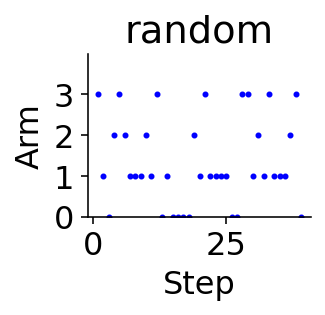

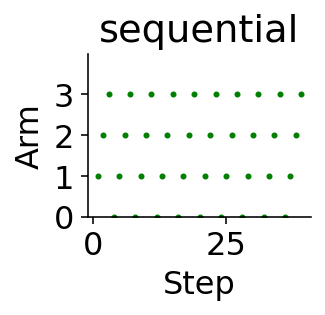

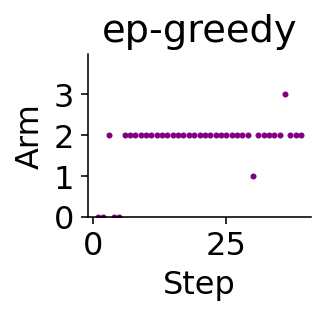

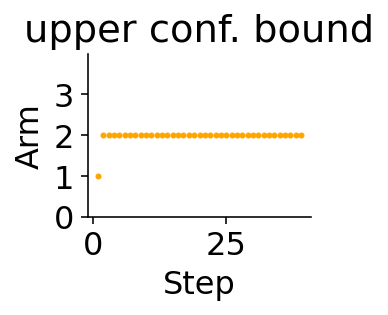

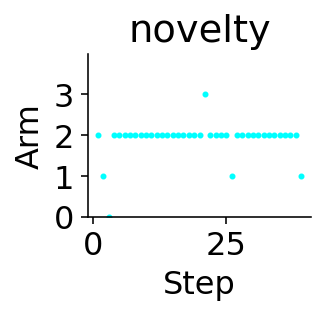

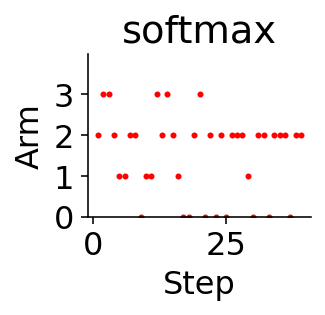

In [11]:
num_experiment = 0
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        num_arms=4,
        s=4,
        title=name, 
        color=color,
        figsize=(2, 1.5)
        )

#### Visualize action choice distributions

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

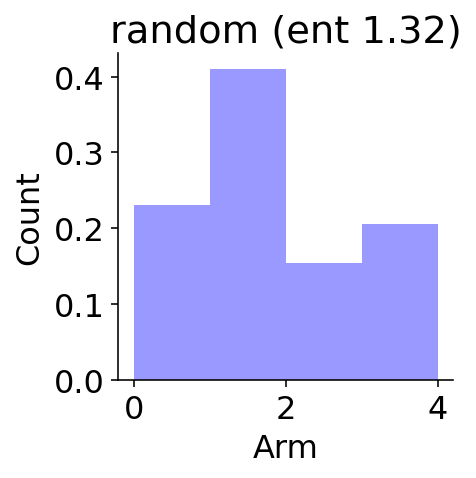

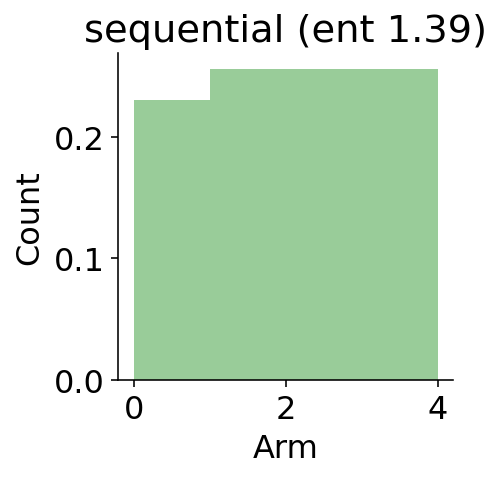

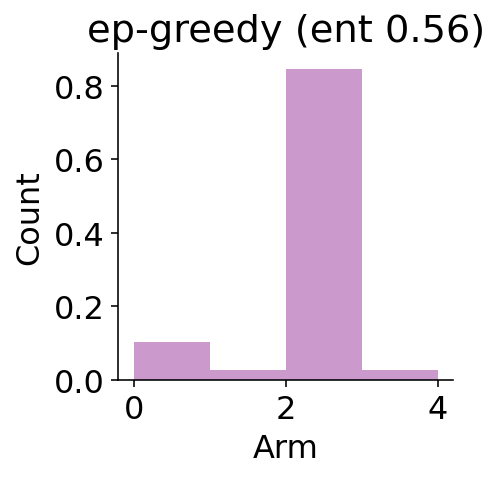

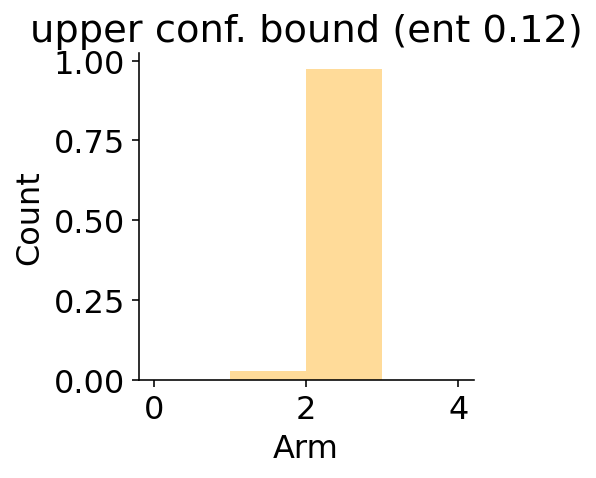

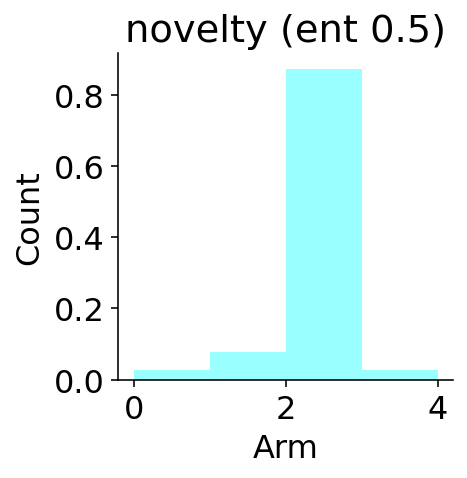

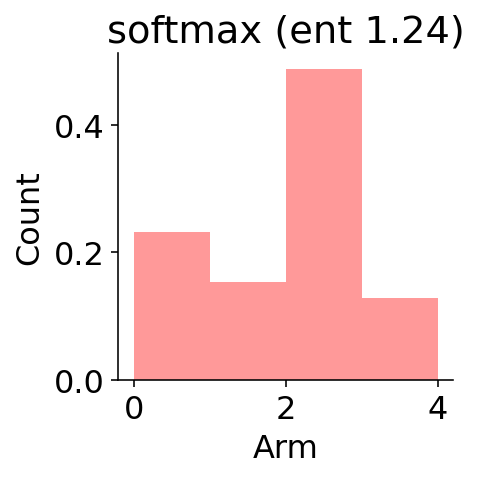

In [12]:
num_experiment = 0
ax = None
for name, res, color in zip(names, results, colors):
    ent = np.round(np.mean(action_entropy(res)), 2)
    plot_bandit_hist(
        select_exp(res, num_experiment), 
        bins=list(range(0, 5)),
        title=f"{name} (ent {ent})", 
        alpha=0.4,
        color=color,
        figsize=(3, 3),
        ax=ax
        )

### Question 3.4
Did the new agents' behaviors match your predictions? If not, why do you think the agents behaved as they did?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

### Question 3.5
If we collect the results of 100 experiments, which agent do you think will do the best on average? Do you think all our new agents will do better than the "old" agents? Why?

In [13]:
# I think softmax will end up doing the best given how it converged. I'm a bit hesitant about novelty and upper conf. given variability.

#### Let's see! Run the next two code cells.

In [14]:
# Run the repeated experiments

num_steps = 4 * 100

results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

random:   0%|          | 0/100 [00:00<?, ?it/s]

sequential:   0%|          | 0/100 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/100 [00:00<?, ?it/s]

upper conf:   0%|          | 0/100 [00:00<?, ?it/s]

novelty:   0%|          | 0/100 [00:00<?, ?it/s]

softmax:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

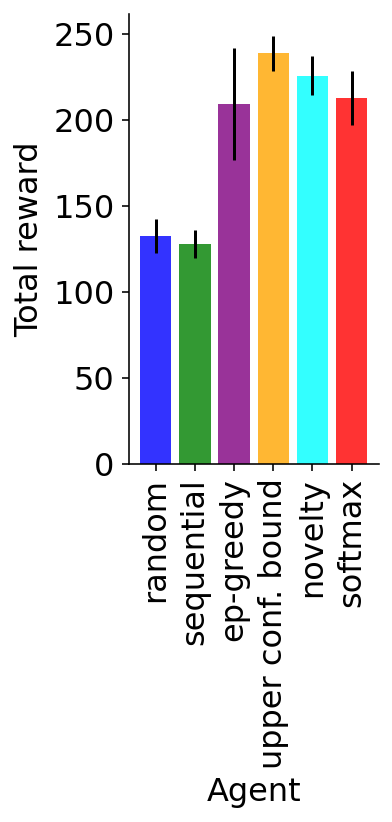

In [15]:
# Visualize total rewards

# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 6))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.xticks(rotation=90)
plt.tight_layout()
sns.despine()

### Question 3.6
Were your predictions correct? If not, what do you think led to the results you saw?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

## Section 4 - Dynamic environment performance

Now, we will consider what can happen when the environment isn't static. We'll build an environment where the reward probability of the best arm changes partway through the task.
- for this, we will make a `BanditChange4` environment. This is also a bandit task environment with 4 arms. However, there are two extra parameters to specify: `p_change` (the probability of reward that the best arm changes to) and `num_change` (the time point at which the change occurs).
- The normal bandit structure plotting code can't handle this type of envionment so there's code below to plot bandits which resemble the task in the two different states.

[5030]

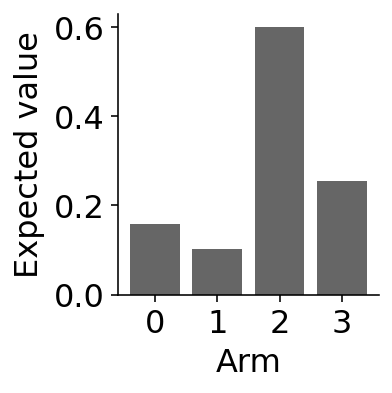

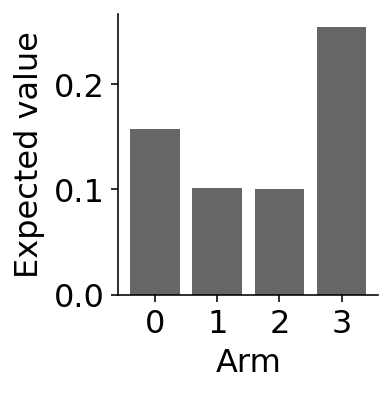

In [16]:
# Shared env params
num_experiments = 1
seed = 5030

# plot env before
envA = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.6)
envA.seed(seed)
plot_bandit(envA, alpha=0.6)

# plot env after
envB = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.1)
envB.seed(seed)
plot_bandit(envB, alpha=0.6)

# Create changing bandit environment
env = BanditChange4(num_change=50, p_min=0.1, p_max=0.3, p_best=0.6, p_change=0.1)
env.seed(seed)

### Question 4.1
Which agent do you think will do the best in this new task? Why?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

In [17]:
# Run the repeated experiments

num_steps = 100

results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

random:   0%|          | 0/100 [00:00<?, ?it/s]

sequential:   0%|          | 0/100 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/100 [00:00<?, ?it/s]

upper conf:   0%|          | 0/100 [00:00<?, ?it/s]

novelty:   0%|          | 0/100 [00:00<?, ?it/s]

softmax:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

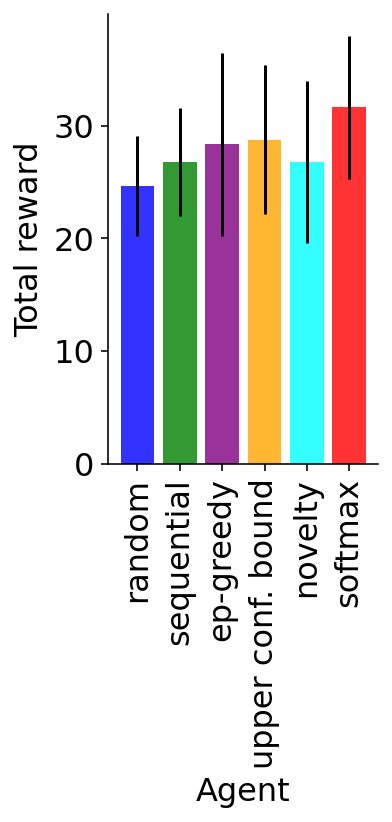

In [18]:
# Visualize total rewards

# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 6))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.xticks(rotation=90)
plt.tight_layout()
sns.despine()

### Question 4.2
Were your predictions correct? If not, why do you think this is the case?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

### Question 4.3
Given what you've learned today, if you had to choose, which algorithm would you follow for balancing exploration and exploitation in your life?

In [ ]:
# Write your answer here, as a comment. Explain yourself.